In [2]:
 # Replace with the actual path to your text file
file_path = '/Users/ben/Documents/mscdatascience/Dissertation/gsknarratives.txt'

def extract_narratives(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            narrative_blocks = []
            
            start_index = 0
            
            while start_index != -1:
                start_index = content.find('Narrative:\n', start_index)
                if start_index != -1:
                    end_index = content.find('Study:', start_index)
                    if end_index != -1:
                        narrative = content[start_index + len('Narrative:\n'):end_index].strip()
                        narrative_blocks.append(narrative)
                        start_index = end_index
                    else:
                        break
            
            return narrative_blocks
    except FileNotFoundError:
        print("File not found.")
        return []

narratives = extract_narratives(file_path)
for i, narrative in enumerate(narratives, start=1):
    print(f"Narrative {i}:\n{narrative}\n")

Narrative 1:
Subject 905387-91119 (75/female/White) was enrolled in Study 4010-01-001-P2B – A Phase 1 Dose Escalation and Cohort Expansion Study of TSR-042, an anti-PD-1 Monoclonal Antibody, in Patients with Advanced Solid Tumors – Part 2B/Cohort A2: MSS endometrial cancer.
The subject was initially diagnosed with Stage IIIc T3aN2M0 endometrial cancer (Grade 3, clear cell carcinoma) on (Date), and the most recent stage was Stage IIIc T3aN2M0. The MMR status for this subject was MMRp; the microsatellite instability status was MSS.
See table below for the regimens, dates, and response/progression information related to the subject’s prior anticancer therapy.
Agent Name (Regimen Number) 
Start Date/ Stop Date 
Best Response 
Date of Progression or Recurrence 
Paclitaxel w/carboplatin (1) 
(Date) (Date) 
/ 
Progressive Disease 
(Date) 
Adjuvant 
Doxorubicin (2) 
(Date) (Date) 
/ 
Partial Response 
(Date) 
Adjuvant 
Reason for Administration 
The subject received the first dose of TSR-042 5

## Further Pre-processing

In [3]:
import string

def preprocess_text(text):
    # Remove hyphens and slashes
    text = text.replace('-', ' ').replace('/', ' ')
    # Remove punctuation except full stops
    text = text.translate(str.maketrans('', '', string.punctuation.replace('.', '')))
    # Convert to lowercase
    text = text.lower()
    # Remove line breaks
    text = text.replace('\n', ' ')
    
    return text

narratives = [preprocess_text(narrative) for narrative in narratives]


In [4]:
len(narratives)

93

## MedCAT SSL

In [4]:
#load in the medmentions concept database
from medcat.cat import CAT

# Specify the path to the model pack directory
model_pack_directory = '/Users/ben/Downloads/medmen_wstatus_2021_oct/'

# Load the model pack
cat = CAT.load_model_pack(model_pack_directory)

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2023-08-23 09:34:09.304518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ben/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, 

In [38]:
# Annotate each patient narrative and save the annotated entities to a list
all_entities = []
for narrative in narratives:
    # Process the narrative using MedCAT and get the annotated entities
    entities = cat.get_entities(narrative, only_cui=False)
    all_entities.extend(entities)

# Perform unsupervised SSL training on the collected entities
cat.train(all_entities, progress_print=100)

# Save the trained model pack
output_model_pack_path = '/Users/ben/Documents/mscdatascience/Dissertation/'
#cat.create_model_pack('/Users/ben/Documents/mscdatascience/Dissertation/'+"unsupervised_trained_model_pack")

'medcat_model_pack_f4d4528c96b2b0f7'

In [5]:
#load ssl modeel
model_pack_path_2 = '/Users/ben/unsupervised_trained_model_pack/medcat_model_pack_f4d4528c96b2b0f7' +".zip"
cat = CAT.load_model_pack(model_pack_path_2)

In [51]:
# IMPORTANT: Set relevant TUI/Type Ids filters to extract relevant info
#T029,Body Location or Region
#T030,Body Space or Junction
#T031,Body Substance
#T032,Organism Attribute
#T033,Finding
#T034,Laboratory or Test Result
#T037,Injury or Poisoning
# |T047|Disease or Syndrome
# |T048|Mental or Behavioral Dysfunction
#T058,Health Care Activity
#T059,Laboratory Procedure
#T060,Diagnostic Procedure
#T074,Medical Device
#T091,Biomedical Occupation or Discipline
#T097,Professional or Occupational Group
# |T100|Age Group
# T101|Patient or Disabled Group
#T099,Family Group
# T098|Population Group
#T195,Antibiotic
#T200,Clinical Drug
#T201,Clinical Attribute
#T203,Drug Delivery Device
type_ids_filter = ['T029', 'T030', 'T031', 'T032', 'T033', 'T034', 'T037',
                   'T047', 'T048', 'T058', 'T059', 'T060', 'T074', 'T091',
                   'T097', 'T098', 'T099', 'T100', 'T101', 'T195', 'T200', 'T201', 'T203']
cui_filters = set()
for type_ids in type_ids_filter:
    cui_filters.update(cat.cdb.addl_info['type_id2cuis'][type_ids])
cat.cdb.config.linking['filters']['cuis'] = cui_filters
print(f"The size of the cdb is now: {len(cui_filters)}")

The size of the cdb is now: 8368


In [30]:
annotated_text = cat.get_entities(narratives)
annotated_text

{'entities': {1: {'pretty_name': 'Females',
   'cui': 'C0086287',
   'type_ids': ['T032'],
   'types': ['Organism Attribute'],
   'source_value': 'female',
   'detected_name': 'female',
   'acc': 0.766680105502665,
   'context_similarity': 0.766680105502665,
   'start': 26,
   'end': 32,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 1,
   'meta_anns': {}},
  2: {'pretty_name': 'Research Subject',
   'cui': 'C0080105',
   'type_ids': ['T098'],
   'types': ['Population Group'],
   'source_value': 'white',
   'detected_name': 'white',
   'acc': 0.5712463228844239,
   'context_similarity': 0.5712463228844239,
   'start': 33,
   'end': 38,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {}},
  3: {'pretty_name': 'Registration',
   'cui': 'C1514821',
   'type_ids': ['T058'],
   'types': ['Health Care Activity'],
   'source_value': 'enrolled',
   'detected_name': 'enrolled',
   'acc': 0.9799507876468334,
   'context_similarity': 0.97995078764

In [31]:
import pandas as pd

# Convert the list of patient narratives into a DataFrame
narratives_df = pd.DataFrame({'text': narratives})

# Now you can format the df to match the in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
in_data = []
for idx, row in narratives_df.iterrows():
    doc_id = idx  # Assuming you want to use the index as the doc_id, you can customize it based on your requirement
    doc_text = row['text']
    in_data.append((doc_id, doc_text))

In [32]:
temp_data = []  # Temporary list to hold data for each narrative

for i, (doc_id, narrative) in enumerate(in_data):
    doc = cat.get_entities(narrative, only_cui=False)

    entities_data = []

    for entity_id, entity_info in doc["entities"].items():
        entities_data.append({
            'cui': entity_info["cui"],
            'start': entity_info["start"],
            'end': entity_info["end"]
        })

    temp_data.append({'doc_id': doc_id, 'narrative': narrative, 'entities': entities_data})

# Convert temp_data into a DataFrame
narratives_df = pd.DataFrame(temp_data)


In [33]:
narratives_df.head()

doc_id                                          narrative  \
0       0  subject 905387 91119 75 female white was enrol...   
1       1  subject 904025 90988 45 female asian was enrol...   
2       2  subject 901021 90986 55 female white was enrol...   
3       3  subject 905485 93646 55 female white was enrol...   
4       4  subject 903302 93943 75 female white was enrol...   

                                            entities  
0  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
1  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
2  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
3  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
4  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...

In [267]:
# Convert the list of patient narratives into a DataFrame
narratives_df = pd.DataFrame({'text': narratives})

# Now you can format the df to match the in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
in_data = []
for idx, row in narratives_df.iterrows():
    doc_id = idx  # Assuming you want to use the index as the doc_id, you can customize it based on your requirement
    doc_text = row['text']
    in_data.append((doc_id, doc_text))
    
temp_data = []  # Temporary list to hold data for each narrative

for i, (doc_id, narrative) in enumerate(in_data):
    doc = cat.get_entities(narrative, only_cui=False)

    entities_data = []

    for entity_id, entity_info in doc["entities"].items():
        entities_data.append({
            'cui': entity_info["cui"],
            'start': entity_info["start"],
            'end': entity_info["end"]
        })

    temp_data.append({'doc_id': doc_id, 'narrative': narrative, 'entities': entities_data})

# Convert temp_data into a DataFrame
narratives_df = pd.DataFrame(temp_data)

In [268]:
narratives_df

doc_id                                          narrative  \
0        0  subject 905387 91119 75 female white was enrol...   
1        1  subject 904025 90988 45 female asian was enrol...   
2        2  subject 901021 90986 55 female white was enrol...   
3        3  subject 905485 93646 55 female white was enrol...   
4        4  subject 903302 93943 75 female white was enrol...   
..     ...                                                ...   
88      88  soc pt  reported term  start date  stop date  ...   
89      89  soc pt  reported term  start date  stop date  ...   
90      90  soc pt  reported term  start date  stop date  ...   
91      91  soc pt  reported term  start date  stop date  ...   
92      92  soc pt  reported term  start date  stop date  ...   

                                             entities  
0   [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
1   [{'cui': 'C0030705', 'start': 0, 'end': 7}, {'...  
2   [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
3   [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
4   [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...  
..                                                ...  
88  [{'cui': 'C0017178', 'start': 103, 'end': 129}...  
89  [{'cui': 'C0243095', 'start': 86, 'end': 93}, ...  
90  [{'cui': 'C0017178', 'start': 118, 'end': 144}...  
91  [{'cui': 'C0014130', 'start': 46, 'end': 65}, ...  
92  [{'cui': 'C0017178', 'start': 118, 'end': 144}...  

[93 rows x 3 columns]

In [269]:
# Function to split the entities into separate lists
def split_entities(entities):
    cuis = [ent['cui'] for ent in entities]
    starts = [ent['start'] for ent in entities]
    ends = [ent['end'] for ent in entities]
    return cuis, starts, ends

# Apply the function and create new columns using pd.Series constructor
narratives_df[['cuis', 'ent_starts', 'ent_ends']] = narratives_df['entities'].apply(lambda x: pd.Series(split_entities(x)))

print(narratives_df)

    doc_id                                          narrative  \
0        0  subject 905387 91119 75 female white was enrol...   
1        1  subject 904025 90988 45 female asian was enrol...   
2        2  subject 901021 90986 55 female white was enrol...   
3        3  subject 905485 93646 55 female white was enrol...   
4        4  subject 903302 93943 75 female white was enrol...   
..     ...                                                ...   
88      88  soc pt  reported term  start date  stop date  ...   
89      89  soc pt  reported term  start date  stop date  ...   
90      90  soc pt  reported term  start date  stop date  ...   
91      91  soc pt  reported term  start date  stop date  ...   
92      92  soc pt  reported term  start date  stop date  ...   

                                             entities  \
0   [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   
1   [{'cui': 'C0030705', 'start': 0, 'end': 7}, {'...   
2   [{'cui': 'C0086287', 'start': 24, 'end': 30}

In [42]:
# Define a mapping of TUI codes to TUI names
tui_code_to_name = {
    'T029': 'Body Location or Region',
    'T030': 'Body Space or Junction',
    'T031': 'Body Substance',
    'T032': 'Organism Attribute',
    'T033': 'Finding',
    'T034': 'Laboratory or Test Result',
    'T037': 'Injury or Poisoning',
    'T047': 'Disease or Syndrome',
    'T048': 'Mental or Behavioral Dysfunction',
    'T058': 'Health Care Activity',
    'T059': 'Laboratory Procedure',
    'T060': 'Diagnostic Procedure',
    'T074': 'Medical Device',
    'T091': 'Biomedical Occupation or Discipline',
    'T097': 'Professional or Occupational Group',
    'T098': 'Population Group',
    'T099': 'Family Group',
    'T100': 'Age Group',
    'T101': 'Patient or Disabled Group',
    'T195': 'Antibiotic',
    'T200': 'Clinical Drug',
    'T201': 'Clinical Attribute',
    'T203': 'Drug Delivery Device'
}

In [62]:
# Function to split the entities and add CUI preferred names and TUI names
def process_entities(entities):
    cuis = [entity['cui'] for entity in entities]
    preferred_names = [cat.cdb.cui2preferred_name.get(cui, 'Unknown Name') for cui in cuis]
    tui_names = [tui_code_to_name.get(tui_code, 'Unknown TUI Name') for cui in cuis for tui_code, cuis_list in cat.cdb.addl_info['type_id2cuis'].items() if cui in cuis_list]
    
    return cuis, preferred_names, tui_names

# Apply the function and create new columns using pd.Series constructor
narratives_df[['cuis', 'ent_preferred_names', 'tui_names']] = narratives_df['entities'].apply(lambda x: pd.Series(process_entities(x)))

In [310]:
# Assuming your DataFrame is named 'df'
narratives_df.to_csv('/Users/ben/Documents/mscdatascience/Dissertation/narratives_df.csv', index=False)

In [63]:
narratives_df.head()

doc_id                                          narrative  \
0       0  subject 905387 91119 75 female white was enrol...   
1       1  subject 904025 90988 45 female asian was enrol...   
2       2  subject 901021 90986 55 female white was enrol...   
3       3  subject 905485 93646 55 female white was enrol...   
4       4  subject 903302 93943 75 female white was enrol...   

                                            entities  \
0  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   
1  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   
2  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   
3  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   
4  [{'cui': 'C0086287', 'start': 24, 'end': 30}, ...   

                                                cuis  \
0  [C0086287, C0080105, C1514821, C0030705, C0599...   
1  [C0086287, C0078988, C1514821, C0030705, C0599...   
2  [C0086287, C0080105, C1514821, C0030705, C0599...   
3  [C0086287, C0080105, C1514821, C0030705, C0599...   
4  [C0086287, C0080105, C1514821, C0030705, C0599...   

                                 ent_preferred_names  \
0  [Females, Research Subject, Registration, Pati...   
1  [Females, Asians, Registration, Patients, Coho...   
2  [Females, Research Subject, Registration, Pati...   
3  [Females, Research Subject, Registration, Pati...   
4  [Females, Research Subject, Registration, Pati...   

                                           tui_names  
0  [Organism Attribute, Population Group, Health ...  
1  [Organism Attribute, Population Group, Health ...  
2  [Organism Attribute, Population Group, Health ...  
3  [Organism Attribute, Population Group, Health ...  
4  [Organism Attribute, Population Group, Health ...

In [274]:
# format the df to match: in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
in_data = []
for id, row in narratives_df[['narrative']].iterrows():
    text = row['narrative']
    in_data.append((id, text))

In [37]:
# Set a batch size to control for the variablity between document sizes
batch_size_chars = 500000 # Batch size (BS) in number of characters

# Run model
results = cat.multiprocessing(in_data, # Formatted data
                              batch_size_chars = batch_size_chars,
                              nproc=8) # Number of processors

In [38]:
# See all annotations based on the filter set above. 
# Notice that entities not present in the filter are filtered out.
cui_list = []
for annotation in list(results[0]['entities'].values()):
    print(annotation['cui'], annotation['pretty_name'])
    print()

C0086287 Females

C0080105 Research Subject

C1514821 Registration

C0030705 Patients

C0599755 Cohort

C0030705 Patients

C0011900 Diagnosis

C1300072 Tumor stage

C1519275 Grade 3 Severe Adverse Event

C0332665 Recent injury

C1300072 Tumor stage

C1300072 Tumor stage

C0030705 Patients

C1704632 Disease Response

C0080105 Research Subject

C0521982 Response to treatment

C1335499 Progressive Disease

C0013089 Doxorubicin

C0521982 Response to treatment

C2349001 Human Study Subject

C2349001 Human Study Subject

C2349001 Human Study Subject

C0599755 Cohort

C0599755 Cohort

C2349001 Human Study Subject

C2349001 Human Study Subject

C0080105 Research Subject

C0744961 history surgical

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medical History

C0262926 Medica

In [39]:
# This will be a map from CUI to a list of documents where it appears: {"cui": [<doc_id>, <doc_id>, ...], ..}
cui_location = {}
# Let's also save the type_ids location
type_ids_location = {}

In [40]:
# For the cui and thier corresponding documents
for doc in list(results.keys()):
    for annotation in list(results[doc]['entities'].values()):
        if annotation['cui'] in cui_location:
            cui_location[annotation['cui']].append(doc)
        else:
            cui_location[annotation['cui']] = [doc]

In [41]:
# For the type_ids and their corresponding documents
# Remember that a cui may map to more than one type_ids (one to many mapping)
for cui in cui_location.keys():
    type_ids_location[list(cat.cdb.cui2type_ids[cui])[0]] = cui_location[cui]

In [42]:
# Create a dictionary to store the occurrence of each CUI in documents
cui_occurrence = {cui: set() for cui in cui_location}

# Iterate through the results and update the occurrence dictionary
for doc, entities in results.items():
    for annotation in entities['entities'].values():
        cui = annotation['cui']
        cui_occurrence[cui].add(doc)

# Calculate the concurrence matrix
num_cuis = len(cui_occurrence)
concurrence_matrix = np.zeros((num_cuis, num_cuis))

for i, cui1 in enumerate(cui_occurrence):
    for j, cui2 in enumerate(cui_occurrence):
        if i != j:
            concurrence = len(cui_occurrence[cui1].intersection(cui_occurrence[cui2]))
            concurrence_matrix[i, j] = concurrence

# Print the concurrence matrix (you can replace this with any further analysis)
print("Concurrence Matrix:")
print(concurrence_matrix)


Concurrence Matrix:
[[ 0. 57. 93. ...  1.  1.  1.]
 [57.  0. 57. ...  1.  1.  1.]
 [93. 57.  0. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  0.  1.  1.]
 [ 1.  1.  1. ...  1.  0.  1.]
 [ 1.  1.  1. ...  1.  1.  0.]]


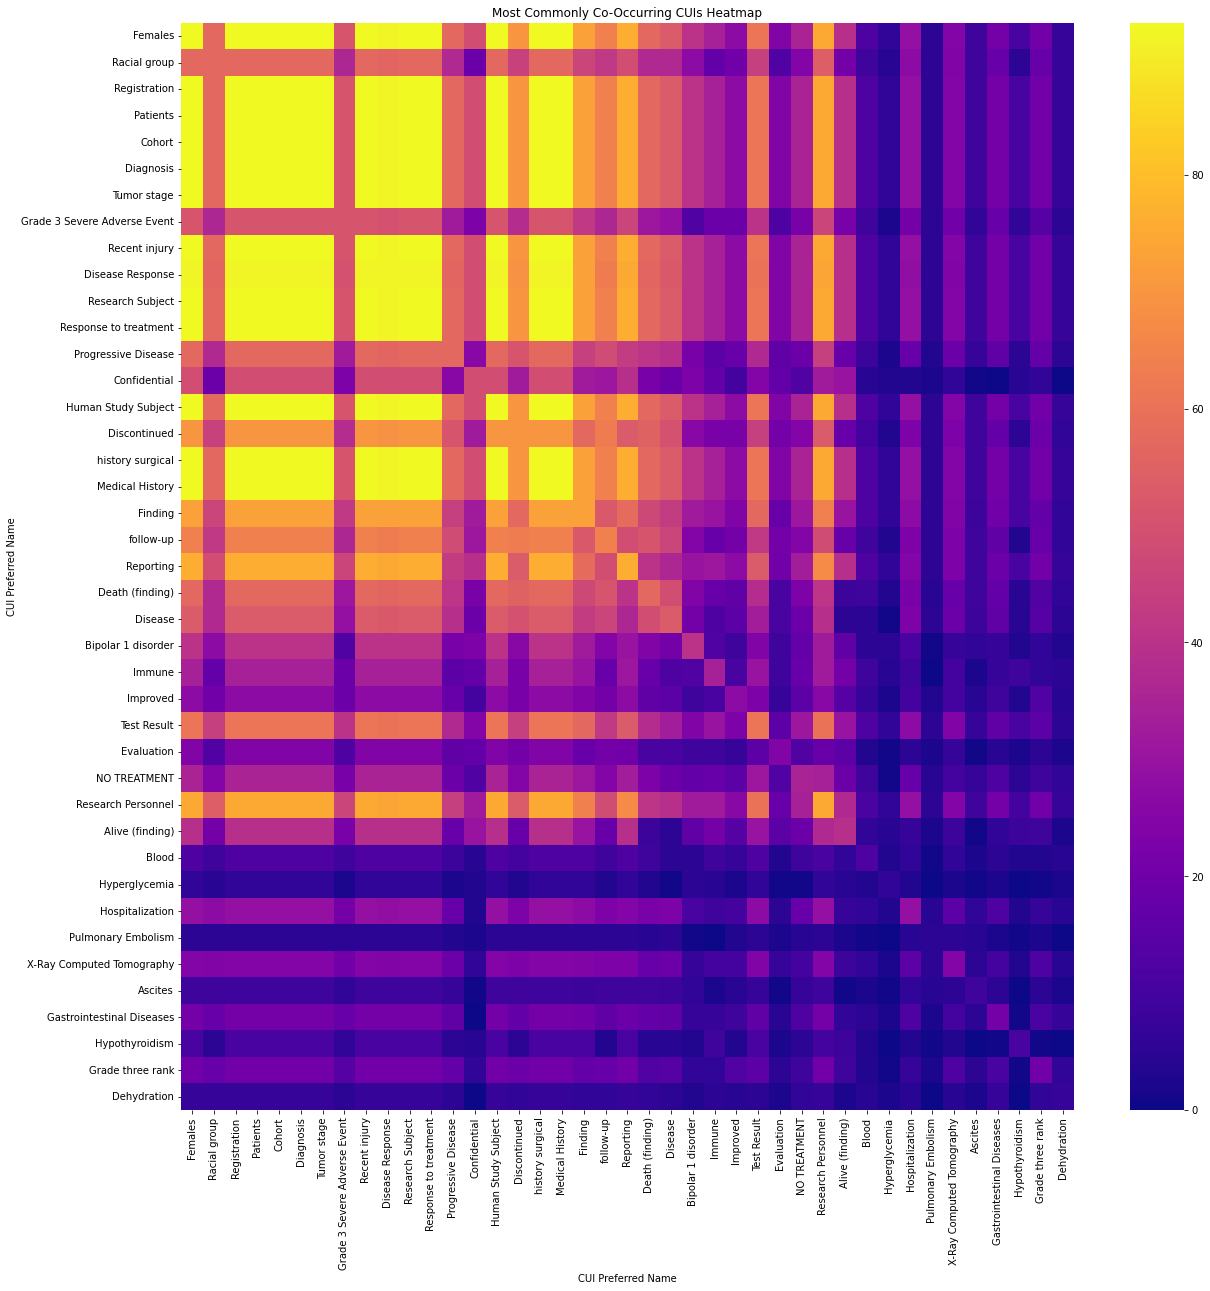

In [43]:
# Step 1: Create the concurrence matrix
cui_list = list(cui_location.keys())
num_cuis = len(cui_list)
concurrence_matrix = np.zeros((num_cuis, num_cuis))

for cui1_idx, cui1 in enumerate(cui_list):
    for cui2_idx, cui2 in enumerate(cui_list):
        common_docs = len(set(cui_location[cui1]).intersection(cui_location[cui2]))
        concurrence_matrix[cui1_idx, cui2_idx] = common_docs

# Step 2: Filter CUIs based on co-occurrence frequency threshold
threshold = 25  # Set your threshold for co-occurrence frequency
common_cuis = [cui for cui, count in cui_location.items() if len(count) >= threshold]

# Filter the concurrence matrix and CUI list
common_cui_indices = [cui_list.index(cui) for cui in common_cuis]
filtered_matrix = concurrence_matrix[common_cui_indices][:, common_cui_indices]
filtered_cui_list = [cui_list[i] for i in common_cui_indices]

# Step 3: Get preferred names of the CUIs
preferred_names = [cat.cdb.cui2preferred_name.get(cui, 'Unknown Name') for cui in filtered_cui_list]

# Step 4: Create a heatmap with actual CUI labels and preferred names
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
sns.heatmap(filtered_matrix, cmap="plasma")
plt.title('Most Commonly Co-Occurring CUIs Heatmap')
plt.xticks(np.arange(len(common_cuis)) + 0.5, preferred_names, rotation=90)
plt.yticks(np.arange(len(common_cuis)) + 0.5, preferred_names, rotation=0)
plt.xlabel('CUI Preferred Name')
plt.ylabel('CUI Preferred Name')
plt.show()


/Users/ben/opt/anaconda3/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:334: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


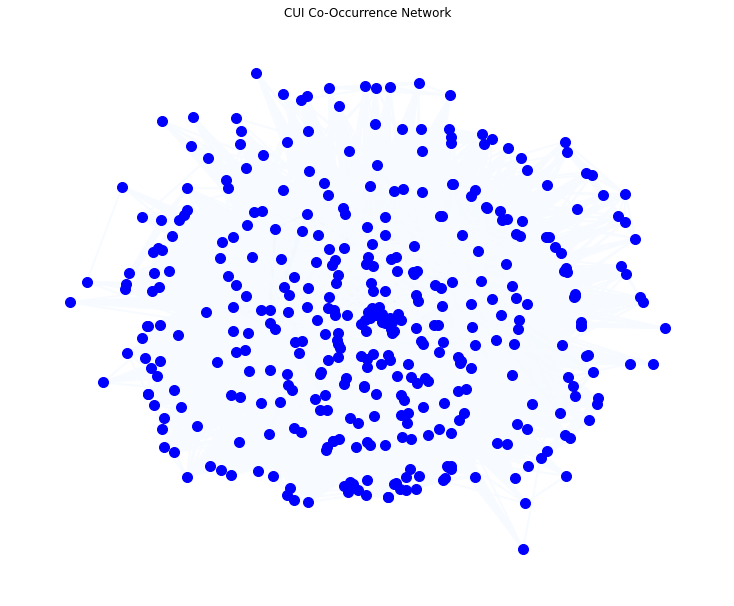

In [69]:
import networkx as nx
# Step 4: Create a Network Visualization using NetworkX
G = nx.Graph()

for cui, docs in cui_location.items():
    G.add_node(cui, docs=docs)

for i in range(len(cui_location)):
    for j in range(i + 1, len(cui_location)):
        if concurrence_matrix[i, j] > 0:
            cui1 = list(cui_location.keys())[i]
            cui2 = list(cui_location.keys())[j]
            weight = concurrence_matrix[i, j]
            G.add_edge(cui1, cui2, weight=weight)

# Draw the network graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Adjust layout algorithm if needed
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, node_size=100, font_size=10, node_color='blue', edgelist=edges, edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
plt.title('CUI Co-Occurrence Network')
plt.show()

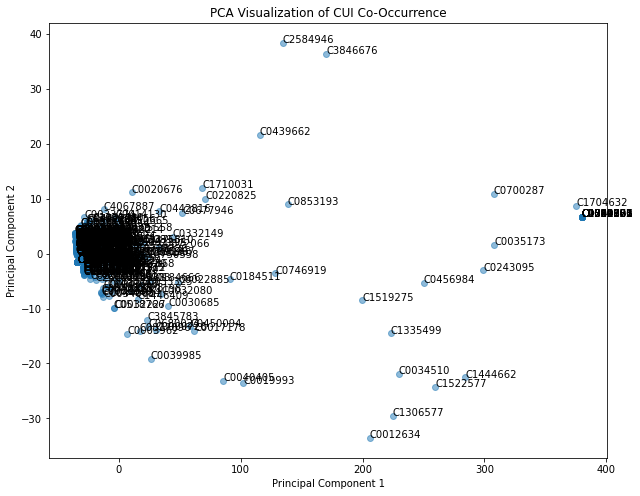

In [45]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the concurrence matrix
num_components = 2  # Number of components for visualization
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(concurrence_matrix)

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Visualization of CUI Co-Occurrence')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Annotate the points with CUI labels
for i, cui in enumerate(cui_list):
    plt.annotate(cui, (pca_result[i, 0], pca_result[i, 1]))

plt.show()

Proximity of Points: CUIs that are close to each other on the PCA plot are more likely to have similar patterns of co-occurrence. Points that are farther apart are less likely to co-occur frequently.
Clusters and Patterns: Look for groups or clusters of points that are close together. These clusters represent sets of CUIs that tend to co-occur together. The more tightly packed the cluster, the stronger the co-occurrence relationship.
Outliers: Points that are isolated or distant from the main clusters may indicate CUIs that have unique co-occurrence patterns or infrequent co-occurrences with other CUIs.
Direction of Axes: The axes in the PCA plot represent the principal components. Points that are aligned in a particular direction along an axis suggest a strong correlation or relationship in the original data.
Explained Variance: Check the explained variance ratio for each principal component. This tells you how much of the total variance in the data is captured by each component. Higher values indicate more important components.
Annotations: The labels near the points represent the CUI numbers. You can refer to your original CUI names and preferred names to understand the medical concepts these CUIs represent.
Interpretation Context: Keep in mind the context of your analysis. Are there specific medical concepts or conditions that you are interested in? Look for patterns that align with your domain knowledge.

In [46]:
#save annotations so they can be reused
import pickle
DATA_DIR = '/Users/ben/Documents/mscdatascience/Dissertation/'
# Save the data so that we don't have to do the annotation again
pickle.dump(cui_location, open(DATA_DIR + "cui_location.dat", 'wb'))
pickle.dump(type_ids_location, open(DATA_DIR + "type_ids_location.dat", 'wb'))

In [47]:
# Load
cui_location = pickle.load(open(DATA_DIR + "cui_location.dat", 'rb'))
type_ids_location = pickle.load(open(DATA_DIR + "type_ids_location.dat", 'rb'))

In [48]:
cui_subjects = {}
cui_subjects_unique = {}

for cui in cui_location:
    subjects_set = set()  # Use a set to store unique subjects for each CUI
    for location in cui_location[cui]:
        subject_id = narratives_df.loc[location, 'doc_id']  # Use 'location' to index into the DataFrame
        subjects_set.add(subject_id)

    cui_subjects[cui] = subjects_set
    cui_subjects_unique[cui] = len(subjects_set)

In [49]:
cui_nsubjects = [('cui', 'nsubjects')]
for cui in cui_subjects_unique.keys():
    n_subjects = cui_subjects_unique[cui]  # Get the number of subjects directly
    cui_nsubjects.append((cui, n_subjects))

df_cui_nsubjects = pd.DataFrame(cui_nsubjects[1:], columns=cui_nsubjects[0])

In [50]:
df_cui_nsubjects = df_cui_nsubjects.sort_values('nsubjects', ascending=False)
# Add type_ids for each CUI
df_cui_nsubjects['type_ids'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    type_ids = cat.cdb.cui2type_ids.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('type_ids')] = type_ids
    
# Add name for each CUI
df_cui_nsubjects['name'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    name = cat.cdb.cui2preferred_name.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('name')] = name


# Add the percentage column
total_subjects = len(narratives_df['doc_id'].unique())
df_cui_nsubjects['perc_subjects'] = (df_cui_nsubjects['nsubjects'] / total_subjects) * 100

df_cui_nsubjects.reset_index(drop=True, inplace=True)

In [68]:
# Inspect newly created df
df_cui_nsubjects.head(25)

cui  nsubjects type_ids                          name  perc_subjects  \
0   C0086287         93   {T032}                       Females     100.000000   
1   C0744961         93   {T033}              history surgical     100.000000   
2   C2349001         93   {T098}           Human Study Subject     100.000000   
3   C0262926         93   {T033}               Medical History     100.000000   
4   C0521982         93   {T201}         Response to treatment     100.000000   
5   C0080105         93   {T098}              Research Subject     100.000000   
6   C0332665         93   {T037}                 Recent injury     100.000000   
7   C1300072         93   {T201}                   Tumor stage     100.000000   
8   C0011900         93   {T060}                     Diagnosis     100.000000   
9   C0599755         93   {T098}                        Cohort     100.000000   
10  C0030705         93   {T101}                      Patients     100.000000   
11  C1514821         93   {T058}                  Registration     100.000000   
12  C1704632         92   {T033}              Disease Response      98.924731   
13  C0700287         76   {T058}                     Reporting      81.720430   
14  C0035173         75   {T097}            Research Personnel      80.645161   
15  C0243095         73   {T033}                       Finding      78.494624   
16  C1444662         70   {T033}                  Discontinued      75.268817   
17  C1522577         64   {T058}                     follow-up      68.817204   
18  C0456984         61   {T034}                   Test Result      65.591398   
19  C1335499         57   {T047}           Progressive Disease      61.290323   
20  C0034510         57   {T098}                  Racial group      61.290323   
21  C1306577         57   {T033}               Death (finding)      61.290323   
22  C0012634         53   {T047}                       Disease      56.989247   
23  C1519275         51   {T033}  Grade 3 Severe Adverse Event      54.838710   
24  C3846676         49   {T033}                  Confidential      52.688172   

          cuis             ent_preferred_names  \
0   [C0086287]                       [Females]   
1   [C0744961]              [history surgical]   
2   [C2349001]           [Human Study Subject]   
3   [C0262926]               [Medical History]   
4   [C0521982]         [Response to treatment]   
5   [C0080105]              [Research Subject]   
6   [C0332665]                 [Recent injury]   
7   [C1300072]                   [Tumor stage]   
8   [C0011900]                     [Diagnosis]   
9   [C0599755]                        [Cohort]   
10  [C0030705]                      [Patients]   
11  [C1514821]                  [Registration]   
12  [C1704632]              [Disease Response]   
13  [C0700287]                     [Reporting]   
14  [C0035173]            [Research Personnel]   
15  [C0243095]                       [Finding]   
16  [C1444662]                  [Discontinued]   
17  [C1522577]                     [follow-up]   
18  [C0456984]                   [Test Result]   
19  [C1335499]           [Progressive Disease]   
20  [C0034510]                  [Racial group]   
21  [C1306577]               [Death (finding)]   
22  [C0012634]                       [Disease]   
23  [C1519275]  [Grade 3 Severe Adverse Event]   
24  [C3846676]                  [Confidential]   

                               tui_names  
0                   [Organism Attribute]  
1                              [Finding]  
2                     [Population Group]  
3                              [Finding]  
4                   [Clinical Attribute]  
5                     [Population Group]  
6                  [Injury or Poisoning]  
7                   [Clinical Attribute]  
8                 [Diagnostic Procedure]  
9                     [Population Group]  
10           [Patient or Disabled Group]  
11                [Health Care Activity]  
12                             [Finding]  

In [54]:
# Function to split the entities and add CUI preferred names and TUI names
def process_entities(entities):
    cuis = [entity['cui'] for entity in entities]
    preferred_names = [cat.cdb.cui2preferred_name.get(cui, 'Unknown Name') for cui in cuis]
    tui_names = [tui_code_to_name.get(tui_code, 'Unknown TUI Name') for cui in cuis for tui_code, cuis_list in cat.cdb.addl_info['type_id2cuis'].items() if cui in cuis_list]
    
    return cuis, preferred_names, tui_names

# Apply the function and create new columns using pd.Series constructor
df_cui_nsubjects[['cuis', 'ent_preferred_names', 'tui_names']] = df_cui_nsubjects['cui'].apply(lambda x: pd.Series(process_entities([{'cui': x}])))

In [55]:
df_cui_nsubjects.head()

cui  nsubjects type_ids                   name  perc_subjects  \
0  C0086287         93   {T032}                Females          100.0   
1  C0744961         93   {T033}       history surgical          100.0   
2  C2349001         93   {T098}    Human Study Subject          100.0   
3  C0262926         93   {T033}        Medical History          100.0   
4  C0521982         93   {T201}  Response to treatment          100.0   

         cuis      ent_preferred_names             tui_names  
0  [C0086287]                [Females]  [Organism Attribute]  
1  [C0744961]       [history surgical]             [Finding]  
2  [C2349001]    [Human Study Subject]    [Population Group]  
3  [C0262926]        [Medical History]             [Finding]  
4  [C0521982]  [Response to treatment]  [Clinical Attribute]

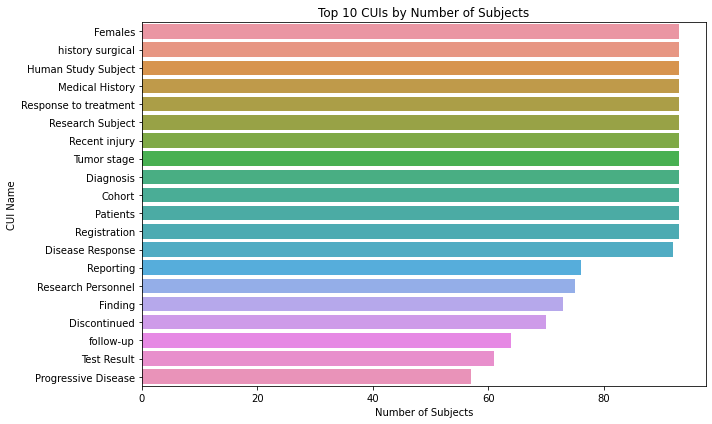

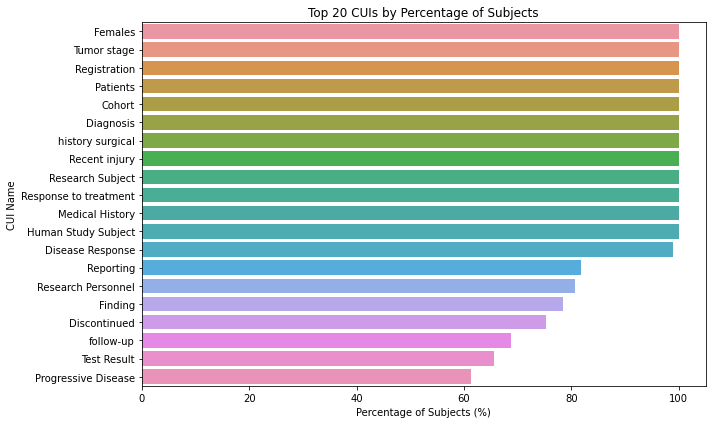

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for top 10 CUIs by nsubjects
top_nsubjects = df_cui_nsubjects.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='nsubjects', y='name', data=top_nsubjects)
plt.xlabel('Number of Subjects')
plt.ylabel('CUI Name')
plt.title('Top 10 CUIs by Number of Subjects')
plt.tight_layout()
plt.show()

# Create a bar plot for top 10 CUIs by perc_subjects
top_perc_subjects = df_cui_nsubjects.sort_values('perc_subjects', ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='perc_subjects', y='name', data=top_perc_subjects)
plt.xlabel('Percentage of Subjects (%)')
plt.ylabel('CUI Name')
plt.title('Top 20 CUIs by Percentage of Subjects')
plt.tight_layout()
plt.show()


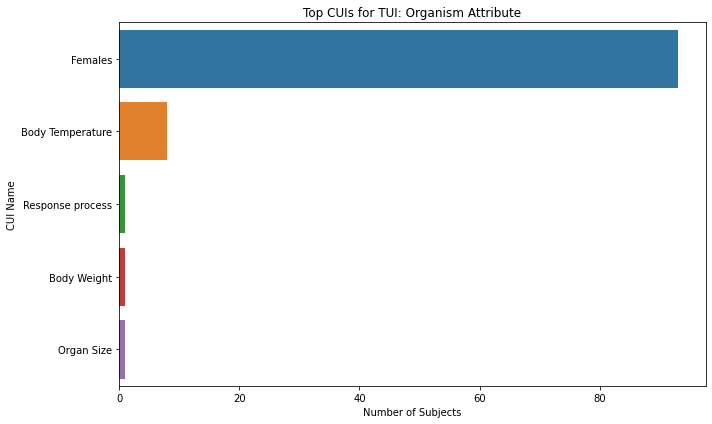

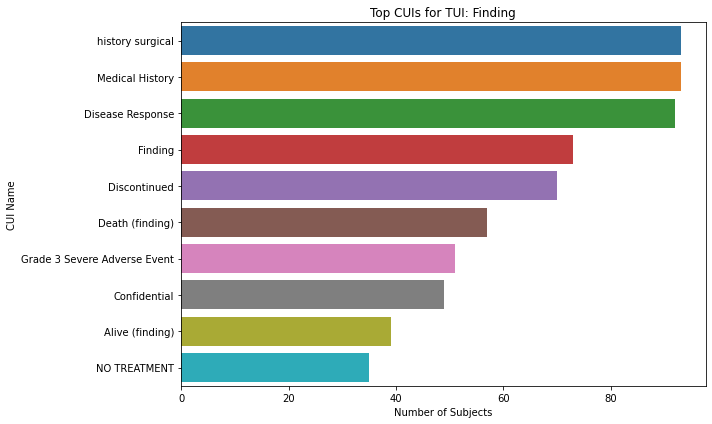

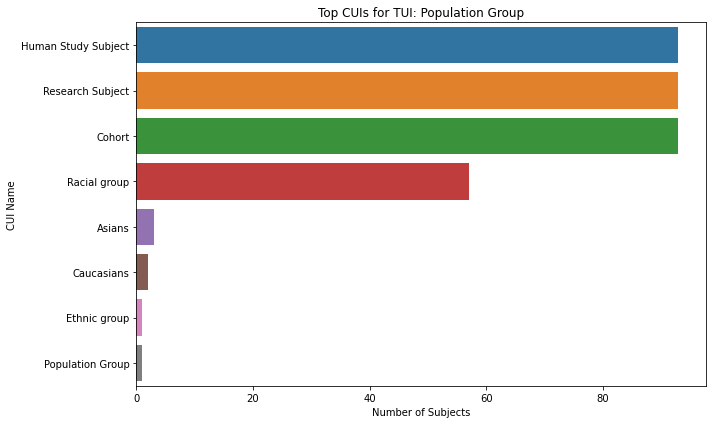

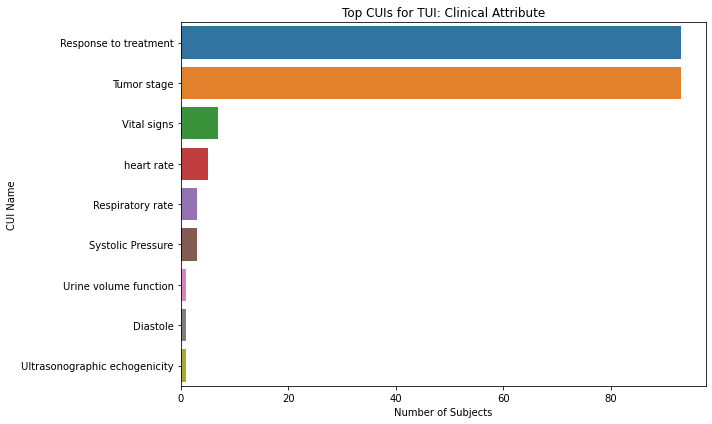

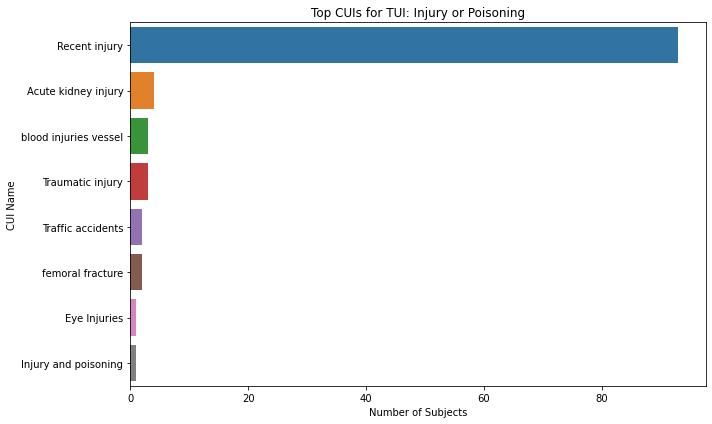

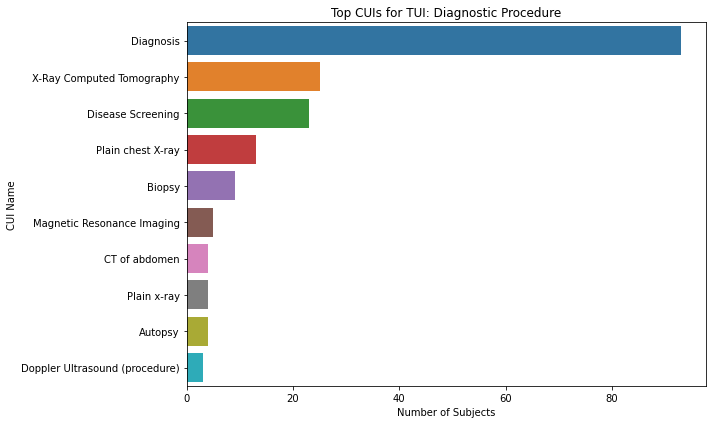

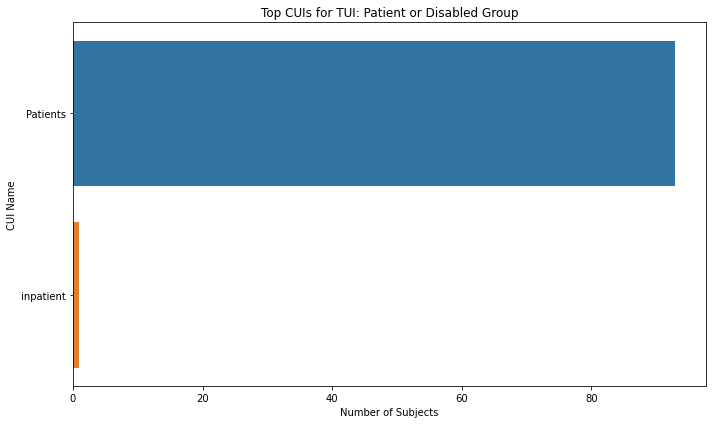

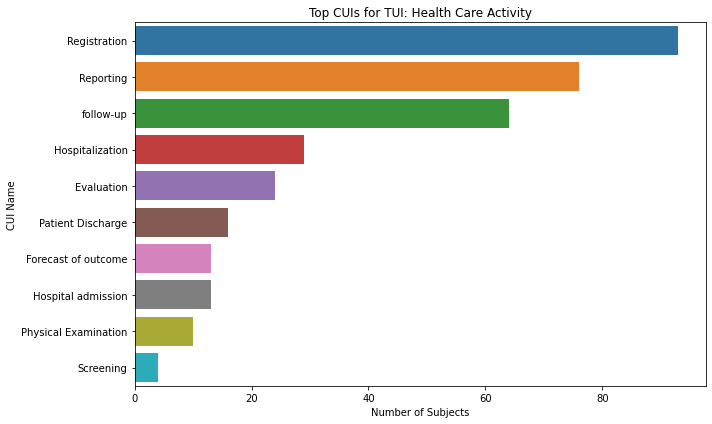

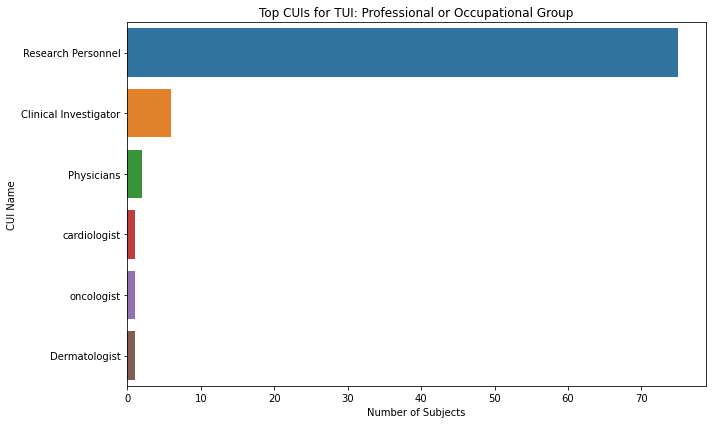

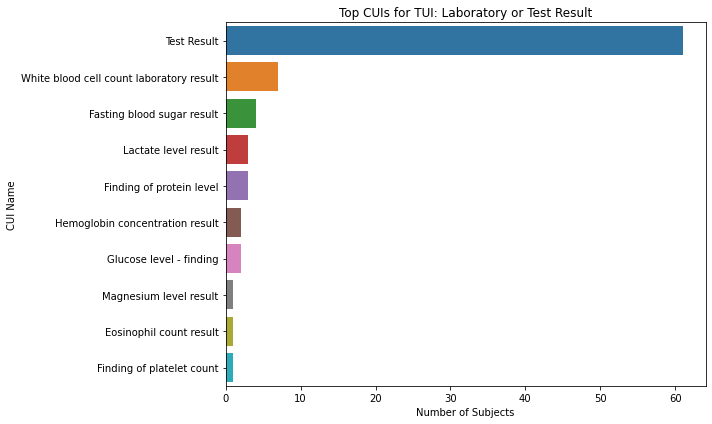

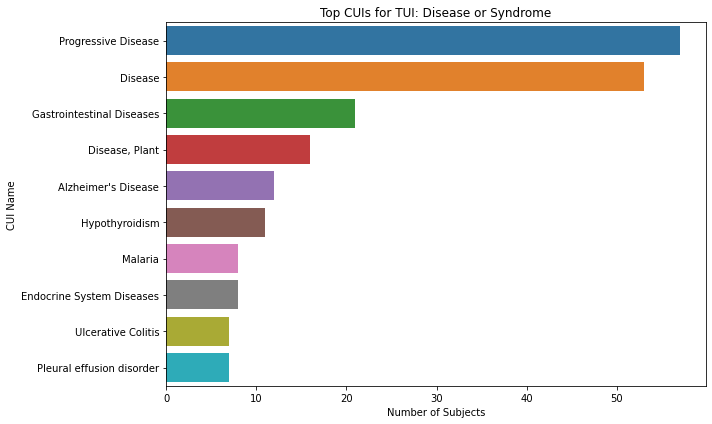

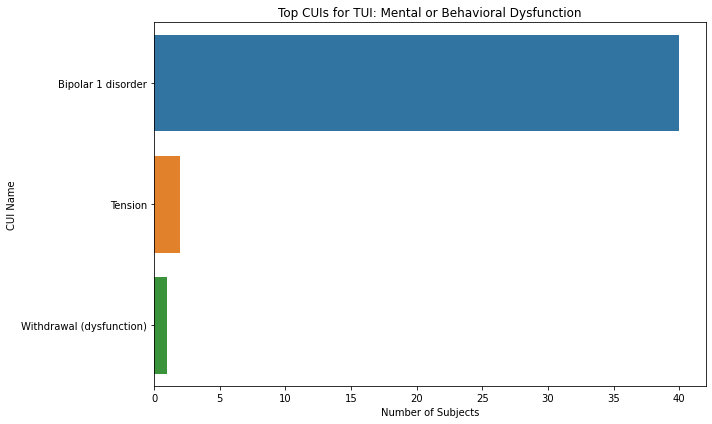

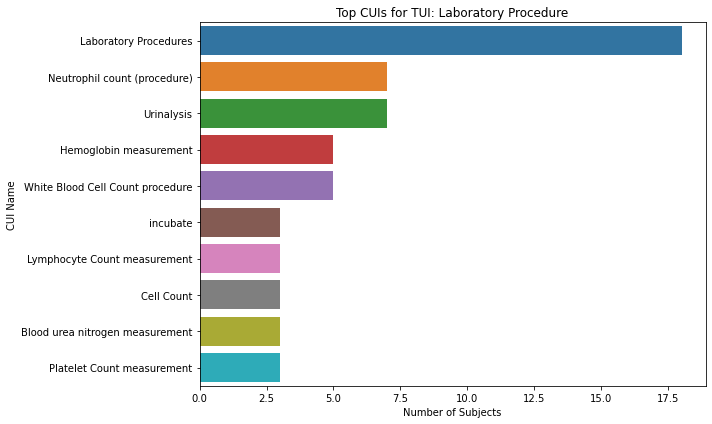

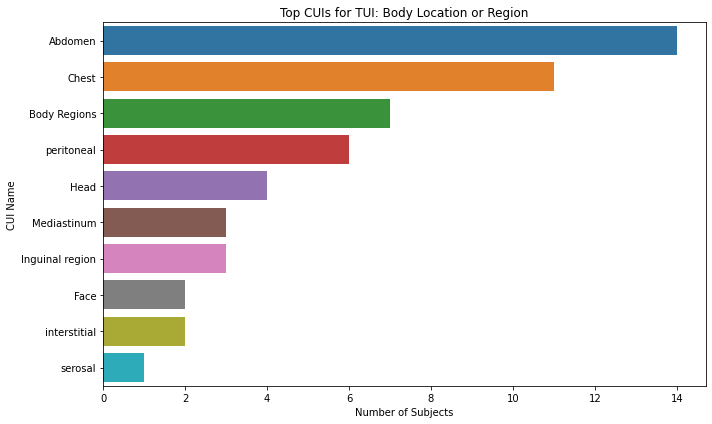

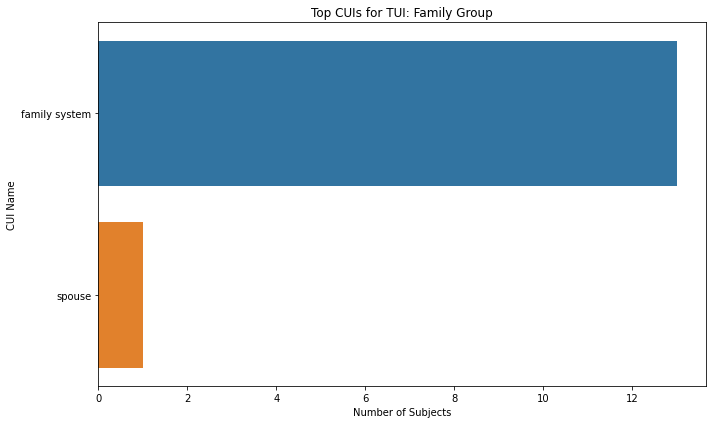

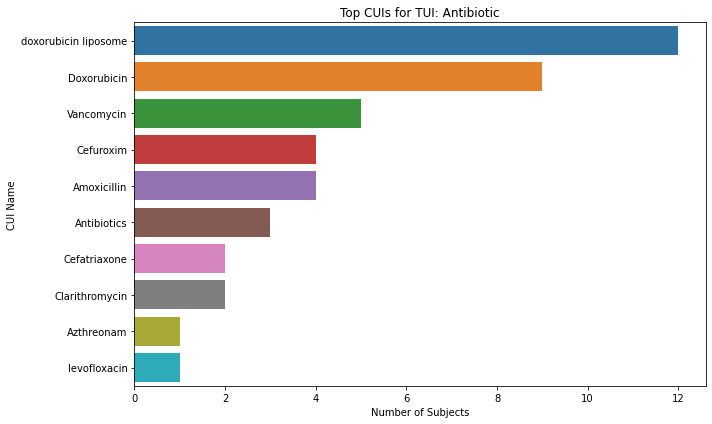

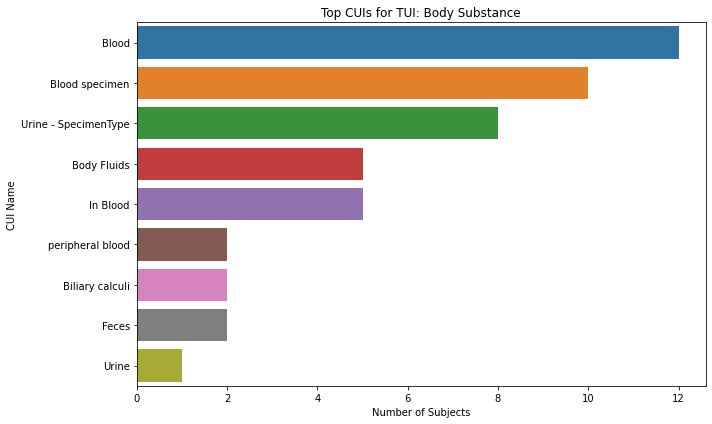

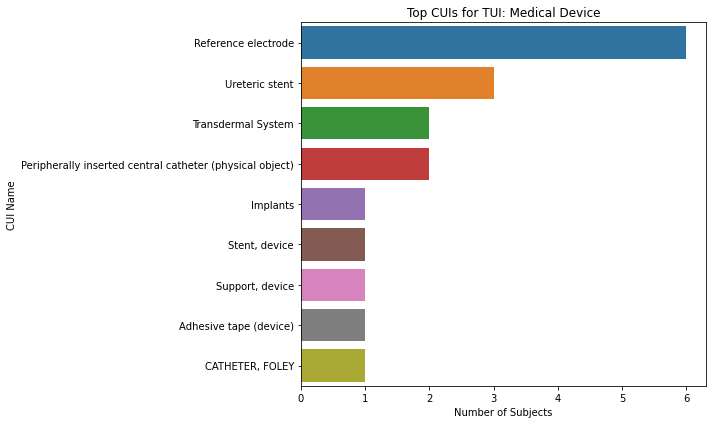

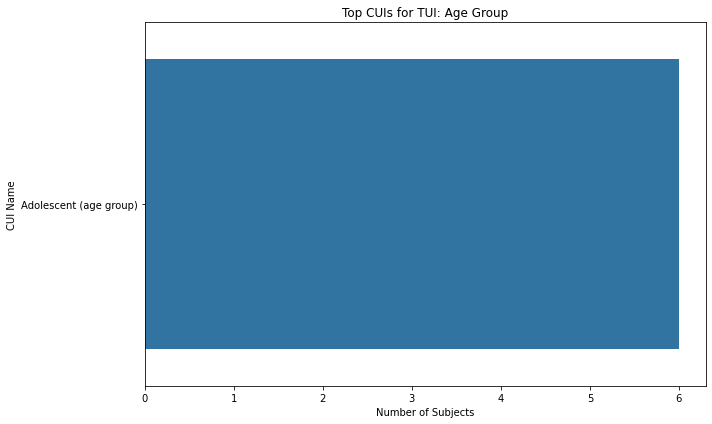

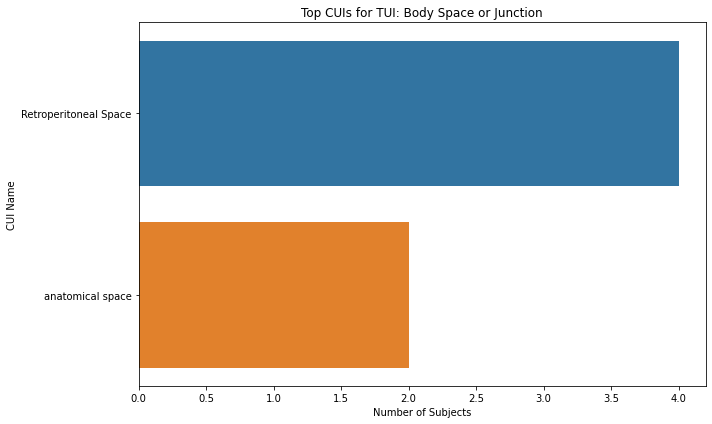

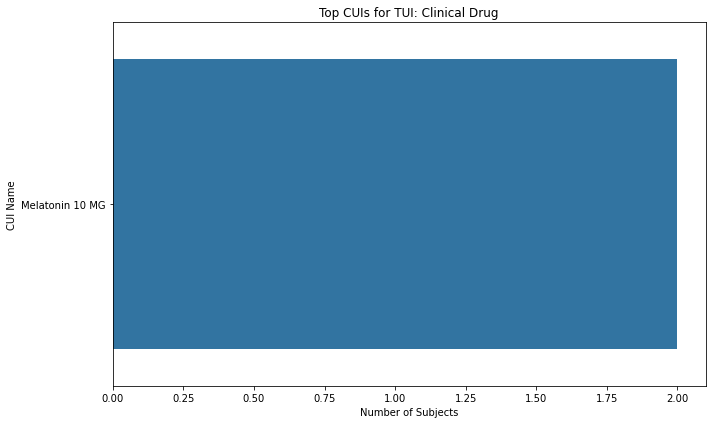

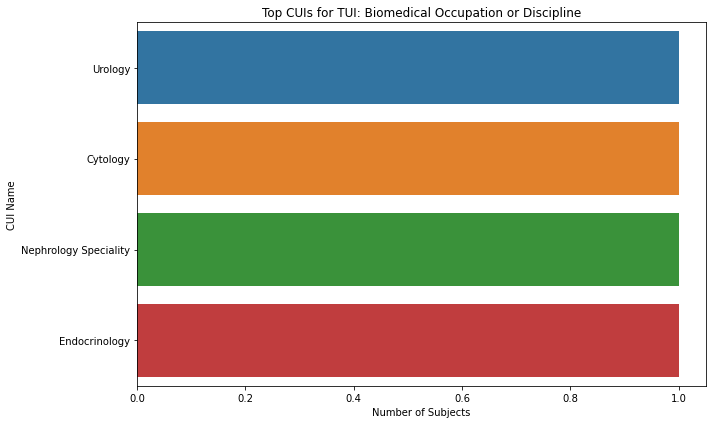

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the DataFrame by TUI codes and iterate over each group
for tui in df_cui_nsubjects['type_ids'].explode().unique():
    tui_df = df_cui_nsubjects[df_cui_nsubjects['type_ids'].apply(lambda x: tui in x)]
    tui_name = tui_code_to_name.get(tui, 'Unknown TUI Name')
    top_cuis = tui_df.head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='nsubjects', y='name', data=top_cuis)
    plt.xlabel('Number of Subjects')
    plt.ylabel('CUI Name')
    plt.title(f'Top CUIs for TUI: {tui_name}')
    plt.tight_layout()
    # Define the filename and file format
    filename = f'/Users/ben/top_cuis_{tui}.png'  # You can adjust the filename as needed
    plt.savefig(filename)  # Save the figure
    
    plt.show()

## MedCAT Supervised Finetuning with MedCATTrainer Annotations

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import json 

from matplotlib import pyplot as plt
from medcat.cat import CAT
from medcat.cdb import CDB
from medcat.config import Config
from medcat.vocab import Vocab
from medcat.meta_cat import MetaCAT
from medcat.config_meta_cat import ConfigMetaCAT
from medcat.preprocessing.tokenizers import TokenizerWrapperBPE, TokenizerWrapperBERT
from tokenizers import ByteLevelBPETokenizer

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2023-08-27 14:29:07.612795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#load in the SSL model
DATA_DIR = '/Users/ben/unsupervised_trained_model_pack/medcat_model_pack_f4d4528c96b2b0f7'
vocab_path = DATA_DIR + "/vocab.dat"
cdb_path = DATA_DIR + "/cdb.dat"

In [25]:
#load in the manually annotated data
import json
data = json.load(open("/Users/ben/Documents/mscdatascience/Dissertation/"  + "MedCAT_Export.json"))

In [8]:
#check the structure of the file
print(data.keys())

dict_keys(['projects'])


In [9]:
data['projects'][0].keys()

dict_keys(['name', 'id', 'cuis', 'documents'])

In [10]:
data['projects'][0]['documents'][0].keys()

dict_keys(['id', 'name', 'text', 'last_modified', 'annotations', 'relations'])

In [11]:
data['projects'][0]['documents'][0]['annotations'][0].keys()

dict_keys(['id', 'user', 'cui', 'value', 'start', 'end', 'validated', 'correct', 'deleted', 'alternative', 'killed', 'irrelevant', 'create_time', 'last_modified', 'comment', 'manually_created', 'acc', 'meta_anns'])

In [27]:
#set up the models using the SSL model pack
# Create and load the CDB (Concept Database)
cdb = CDB.load(cdb_path)

# Create and load the Vocabulary
vocab = Vocab.load(vocab_path)

# Setup config
config = Config()
config.general['spacy_model'] = 'en_core_web_md'

# Create CAT - the main class from medcat used for concept annotation
cat = CAT(cdb=cdb, config=config, vocab=vocab)

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [28]:
#perform supervised finetuning
cat.train_supervised(data_path="/Users/ben/Documents/mscdatascience/Dissertation/"  + "MedCAT_Export.json", 
                     nepochs=5,
                     reset_cui_count=False,
                     print_stats=True, 
                     use_filters=True) 

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/medcat/utils/decorators.py:11: UserWarning: Function train_supervised has been deprecated. Use train_supervised_from_json to train based on data loaded from a json file
  warnings.warn("Function {} has been deprecated.{}".format(func.__name__, " " + message if message else ""))


Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Prec: 0.8626476072094469, Rec: 0.4858242912145607, F1: 0.6215853112404837

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

History of previous events                                             - C2004062             -         75
Patients                                                               - C0030705             -         18
Value type - Date                                                      - C1548309             -         13
History                                                                - C0019664             -         13
Intellectual Product                                                   - C0282574             -          9
Historical aspects qualifier                                           - C0019665             -          8
Normal                                                                 - C0205307             -          7
Duration (temporal concept)    

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/10 [00:00<?, ?it/s]

Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Prec: 0.9315673289183223, Rec: 0.7385369268463423, F1: 0.8238969152674736

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

Medical History                                                        - C0262926             -         54
Human Study Subject                                                    - C2349001             -         16
Value type - Date                                                      - C1548309             -         10
Test Result                                                            - C0456984             -         10
chemotherapy cycle                                                     - C1302181             -          8
Date in time                                                           - C0011008             -          7
Duration (temporal concept)                                            - C0449238             -          4
Values                         

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/10 [00:00<?, ?it/s]

Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2, Prec: 0.9329918907383696, Rec: 0.7651382569128456, F1: 0.8407692307692309

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

Medical History                                                        - C0262926             -         54
Human Study Subject                                                    - C2349001             -         17
Test Result                                                            - C0456984             -         13
Date in time                                                           - C0011008             -          9
chemotherapy cycle                                                     - C1302181             -          6
Time                                                                   - C0040223             -          6
data report                                                            - C0011000             -          5
Value type - Date              

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/10 [00:00<?, ?it/s]

Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3, Prec: 0.9333895446880269, Rec: 0.7749387469373469, F1: 0.846815834767642

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

Medical History                                                        - C0262926             -         54
Human Study Subject                                                    - C2349001             -         18
Date in time                                                           - C0011008             -         14
Test Result                                                            - C0456984             -         13
Time                                                                   - C0040223             -          7
chemotherapy cycle                                                     - C1302181             -          6
data report                                                            - C0011000             -          5
Value type - Date               

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/10 [00:00<?, ?it/s]

Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, Prec: 0.9260504201680673, Rec: 0.7714385719285964, F1: 0.841703265228184

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

Medical History                                                        - C0262926             -         54
Date in time                                                           - C0011008             -         36
Human Study Subject                                                    - C2349001             -         18
Test Result                                                            - C0456984             -         12
Time                                                                   - C0040223             -          7
data report                                                            - C0011000             -          5
Value type - Date                                                      - C1548309             -          4
Research Subject                

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/10 [00:00<?, ?it/s]

Stats project:   0%|          | 0/1 [00:00<?, ?it/s]

Stats document:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5, Prec: 0.9212070410729254, Rec: 0.7693384669233462, F1: 0.8384512683578105

Docs with false positives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10

Docs with false negatives: 2; 6; 9; 7; 8; 4; 3; 5; 1; 10



False Positives

Medical History                                                        - C0262926             -         54
Date in time                                                           - C0011008             -         46
Human Study Subject                                                    - C2349001             -         18
Test Result                                                            - C0456984             -         12
Time                                                                   - C0040223             -          7
Research Subject                                                       - C0080105             -          5
data report                                                            - C0011000             -          5
Value type - Date              

({'C0262926': 54,
  'C0011008': 46,
  'C2349001': 18,
  'C0456984': 12,
  'C0040223': 7,
  'C0080105': 5,
  'C0011000': 5,
  'C1548309': 4,
  'C1514821': 3,
  'C0521982': 3,
  'C1302181': 3,
  'C0877248': 3,
  'C0019988': 2,
  'C1527428': 2,
  'C0750591': 2,
  'C0034925': 2,
  'C1254351': 1,
  'C0001551': 1,
  'C0243095': 1,
  'C1522446': 1,
  'C0681850': 1,
  'C0242656': 1,
  'C0034897': 1,
  'C1254363': 1,
  'C0033774': 1,
  'C0023672': 1,
  'C4067887': 1,
  'C1442488': 1,
  'C0392201': 1,
  'C0043481': 1,
  'C1710031': 1,
  'C0683954': 1,
  'C1522609': 1},
 {'C1254363': 191,
  'C0439228': 143,
  'C1548309': 46,
  'C2004062': 35,
  'C0030705': 24,
  'C0009932': 23,
  'C0007004': 14,
  'C0019664': 12,
  'C0040160': 11,
  'C0024485': 10,
  'C0312452': 10,
  'C0370097': 9,
  'C0585361': 8,
  'C0019665': 7,
  'C0037813': 7,
  'C0920269': 7,
  'C0444930': 7,
  'C0449238': 6,
  'C0700287': 5,
  'C1274040': 5,
  'C0201836': 5,
  'C0243095': 5,
  'C0011008': 4,
  'C0201899': 4,
  'C1511726':

### go back up to extract entities with the finelytuned MedCAT model

# medspacy

In [76]:
# Convert the lists in the "tui_names" column to strings
top_perc_subjects['tui_names'] = top_perc_subjects['tui_names'].apply(lambda x: x[0])

In [77]:
top_perc_subjects

cui  nsubjects type_ids                   name  perc_subjects  \
0   C0086287         93   {T032}                Females     100.000000   
7   C1300072         93   {T201}            Tumor stage     100.000000   
11  C1514821         93   {T058}           Registration     100.000000   
10  C0030705         93   {T101}               Patients     100.000000   
9   C0599755         93   {T098}                 Cohort     100.000000   
8   C0011900         93   {T060}              Diagnosis     100.000000   
1   C0744961         93   {T033}       history surgical     100.000000   
6   C0332665         93   {T037}          Recent injury     100.000000   
5   C0080105         93   {T098}       Research Subject     100.000000   
4   C0521982         93   {T201}  Response to treatment     100.000000   
3   C0262926         93   {T033}        Medical History     100.000000   
2   C2349001         93   {T098}    Human Study Subject     100.000000   
12  C1704632         92   {T033}       Disease Response      98.924731   
13  C0700287         76   {T058}              Reporting      81.720430   
14  C0035173         75   {T097}     Research Personnel      80.645161   
15  C0243095         73   {T033}                Finding      78.494624   
16  C1444662         70   {T033}           Discontinued      75.268817   
17  C1522577         64   {T058}              follow-up      68.817204   
18  C0456984         61   {T034}            Test Result      65.591398   
19  C1335499         57   {T047}    Progressive Disease      61.290323   

          cuis      ent_preferred_names                           tui_names  
0   [C0086287]                [Females]                  Organism Attribute  
7   [C1300072]            [Tumor stage]                  Clinical Attribute  
11  [C1514821]           [Registration]                Health Care Activity  
10  [C0030705]               [Patients]           Patient or Disabled Group  
9   [C0599755]                 [Cohort]                    Population Group  
8   [C0011900]              [Diagnosis]                Diagnostic Procedure  
1   [C0744961]       [history surgical]                             Finding  
6   [C0332665]          [Recent injury]                 Injury or Poisoning  
5   [C0080105]       [Research Subject]                    Population Group  
4   [C0521982]  [Response to treatment]                  Clinical Attribute  
3   [C0262926]        [Medical History]                             Finding  
2   [C2349001]    [Human Study Subject]                    Population Group  
12  [C1704632]       [Disease Response]                             Finding  
13  [C0700287]              [Reporting]                Health Care Activity  
14  [C0035173]     [Research Personnel]  Professional or Occupational Group  
15  [C0243095]                [Finding]                             Finding  
16  [C1444662]           [Discontinued]                             Finding  
17  [C1522577]              [follow-up]                Health Care Activity  
18  [C0456984]            [Test Result]           Laboratory or Test Result  
19  [C1335499]    [Progressive Disease]                 Disease or Syndrome

In [88]:
import medspacy
from medspacy.ner import TargetRule

# Load the default medspacy model
nlp = medspacy.load(enable=["ner"])

# Get the existing TargetMatcher component from the pipeline
target_matcher = nlp.get_pipe("medspacy_target_matcher")

# Assuming you have the DataFrame 'top_perc_subjects'
for tui_name, tui_group in top_perc_subjects.groupby("tui_names"):
    top_tui_group = tui_group.nlargest(20, "nsubjects")  # Select top 10 highest nsubjects
    
    cui_patterns = []
    for idx, row in top_tui_group.iterrows():
        cui_name = row['name']  # Assuming you have a 'name' column in your DataFrame
        
        cui_patterns.append(
            TargetRule(
                cui_name,      # Use name as the label
                category=tui_name,   # Use TUI name as the category
                pattern=cui_name,    # Use name as the pattern
            )
        )
    
    target_matcher.add(cui_patterns)




In [89]:
from medspacy.visualization import visualize_ent
# Process each preprocessed narrative using MedSpaCy, starting from 0
for i, narrative in enumerate(narratives):
    doc = nlp(narrative)
    
    # Visualize the extracted entities
    visualize_ent(doc)
    
    # Extract entities by TUI name
    entities_by_tui_name = {tui: [] for tui in top_perc_subjects['tui_names'].unique()}
    for ent in doc.ents:
        entities_by_tui_name[ent.label_].append(ent.text)
    
    # Print the extracted entities for each TUI name
    for tui_name, entities in entities_by_tui_name.items():
        print(f"Narrative {i} - Extracted Entities for TUI Name '{tui_name}': {entities}")

Narrative 0 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 0 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 0 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 0 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 0 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 0 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 0 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings']
Narrative 0 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 0 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 0 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 0 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 1 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 1 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 1 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 1 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 1 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 1 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 1 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 1 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 1 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 1 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 1 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 2 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 2 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 2 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 2 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 2 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 2 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 2 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 2 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 2 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 2 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 2 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 3 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 3 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 3 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 3 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 3 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 3 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 3 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 3 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 3 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 3 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 3 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 4 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 4 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 4 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 4 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 4 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 4 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 4 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 4 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 4 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 4 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 4 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 5 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 5 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 5 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 5 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 5 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 5 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 5 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 5 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 5 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 5 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 5 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 6 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 6 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 6 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 6 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 6 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 6 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 6 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 6 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 6 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 6 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 6 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 7 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 7 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 7 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 7 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 7 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 7 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 7 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 7 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 7 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 7 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 7 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 8 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 8 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 8 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 8 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 8 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 8 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 8 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 8 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 8 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 8 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test result', 'test results', 'test results', 'test results', 'test results']
Narrative 8 - Extracted Entities for TU

Narrative 9 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 9 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 9 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 9 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 9 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 9 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 9 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 9 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 9 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 9 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 9 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 10 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 10 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 10 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 10 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 10 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 10 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 10 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings']
Narrative 10 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 10 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 10 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 10 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 11 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 11 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 11 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 11 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 11 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 11 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 11 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 11 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 11 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 11 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 11 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 12 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 12 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 12 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 12 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 12 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 12 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 12 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history']
Narrative 12 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 12 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 12 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 12 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive 

Narrative 13 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 13 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 13 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 13 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 13 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 13 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 13 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 13 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 13 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 13 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 13 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 14 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 14 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 14 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 14 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 14 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 14 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 14 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 14 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 14 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 14 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 14 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 15 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 15 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 15 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 15 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 15 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 15 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 15 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 15 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 15 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 15 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 15 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 16 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 16 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 16 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 16 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 16 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 16 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 16 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 16 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 16 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 16 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 16 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 17 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 17 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 17 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 17 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 17 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 17 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 17 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history', 'discontinued', 'discontinued']
Narrative 17 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 17 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 17 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results']
Narrative 17 - Extracted 

Narrative 18 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 18 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 18 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 18 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 18 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 18 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 18 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 18 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 18 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 18 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 18 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 19 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 19 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 19 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 19 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 19 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 19 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 19 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 19 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 19 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 19 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 19 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 20 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 20 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 20 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 20 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 20 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 20 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 20 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings']
Narrative 20 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 20 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 20 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 20 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 21 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 21 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 21 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 21 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 21 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 21 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 21 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings', 'findings']
Narrative 21 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 21 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 21 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 21 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 22 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 22 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 22 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 22 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 22 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 22 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 22 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings']
Narrative 22 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 22 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 22 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 22 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 23 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 23 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 23 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 23 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 23 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 23 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 23 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 23 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 23 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 23 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 23 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 24 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 24 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 24 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 24 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 24 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 24 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 24 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 24 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 24 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 24 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 24 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 25 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 25 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 25 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 25 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 25 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 25 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 25 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 25 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 25 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 25 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 25 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 26 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 26 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 26 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 26 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 26 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 26 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 26 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 26 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 26 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 26 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 26 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 27 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 27 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 27 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 27 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 27 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 27 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 27 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history', 'medical history']
Narrative 27 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 27 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 27 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 27 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 28 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 28 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 28 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 28 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 28 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 28 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 28 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 28 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 28 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 28 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 28 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 29 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 29 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 29 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 29 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 29 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 29 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 29 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings', 'discontinued']
Narrative 29 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 29 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 29 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 29 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 30 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 30 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 30 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 30 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 30 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 30 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 30 - Extracted Entities for TUI Name 'Finding': ['medical history', 'medical history']
Narrative 30 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 30 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 30 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 30 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 31 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 31 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 31 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 31 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 31 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 31 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 31 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued', 'findings', 'findings']
Narrative 31 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 31 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 31 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 31 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 32 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 32 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 32 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 32 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 32 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 32 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 32 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history']
Narrative 32 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 32 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 32 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 32 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 33 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 33 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 33 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 33 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 33 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 33 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 33 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 33 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 33 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 33 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 33 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 34 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 34 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 34 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 34 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 34 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 34 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 34 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 34 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 34 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 34 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 34 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 35 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 35 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 35 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 35 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 35 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort']
Narrative 35 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 35 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued']
Narrative 35 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 35 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 35 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results', 'test results', 'test results']
Narrative 35 - Extracted Entities for TUI Name 'Disease or Syndrome

Narrative 36 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 36 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 36 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 36 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 36 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 36 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 36 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 36 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 36 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 36 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 36 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 37 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 37 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 37 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 37 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 37 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 37 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 37 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 37 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 37 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 37 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 37 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 38 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 38 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 38 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 38 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 38 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 38 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 38 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 38 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 38 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 38 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 38 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'pro

Narrative 39 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 39 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 39 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 39 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 39 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 39 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 39 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 39 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 39 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 39 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 39 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 40 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 40 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 40 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 40 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 40 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 40 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 40 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 40 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 40 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 40 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 40 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 41 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 41 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 41 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 41 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 41 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 41 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 41 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history', 'findings', 'discontinued']
Narrative 41 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 41 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 41 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results']
Narrative 41 - Extracted Entities

Narrative 42 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 42 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 42 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 42 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 42 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 42 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 42 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'findings', 'discontinued']
Narrative 42 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 42 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 42 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results']
Narrative 42

Narrative 43 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 43 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 43 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 43 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 43 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 43 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 43 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 43 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 43 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 43 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results', 'test results', 'test results']
Narrative 43 - Extracted Ent

Narrative 44 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 44 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 44 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 44 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 44 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 44 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 44 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 44 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 44 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 44 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 44 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 45 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 45 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 45 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 45 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 45 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 45 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 45 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 45 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 45 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 45 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 45 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 46 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 46 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 46 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 46 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 46 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 46 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 46 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 46 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 46 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 46 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 46 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 47 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 47 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 47 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 47 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 47 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 47 - Extracted Entities for TUI Name 'Diagnostic Procedure': ['diagnosis']
Narrative 47 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 47 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 47 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 47 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 47 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressi

Narrative 48 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 48 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 48 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 48 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 48 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 48 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 48 - Extracted Entities for TUI Name 'Finding': ['medical history', 'medical history']
Narrative 48 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 48 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 48 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 48 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 49 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 49 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 49 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 49 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 49 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 49 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 49 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 49 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 49 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 49 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 49 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 50 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 50 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 50 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 50 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 50 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 50 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 50 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 50 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 50 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 50 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 50 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'pro

Narrative 51 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 51 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 51 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 51 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 51 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 51 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 51 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 51 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 51 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 51 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 51 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 52 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 52 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 52 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 52 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 52 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 52 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 52 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings', 'findings', 'findings']
Narrative 52 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 52 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 52 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 52 - Extracted Entities for TUI Name 'Disease 

Narrative 53 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 53 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 53 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 53 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 53 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 53 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 53 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'finding', 'discontinued']
Narrative 53 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 53 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 53 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test result', 'test results', 'test

Narrative 54 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 54 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 54 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 54 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 54 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 54 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 54 - Extracted Entities for TUI Name 'Finding': ['medical history', 'medical history']
Narrative 54 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 54 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 54 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 54 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 55 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 55 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 55 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 55 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 55 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 55 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 55 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 55 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 55 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 55 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 55 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 56 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 56 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 56 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting', 'reporting']
Narrative 56 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 56 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort', 'cohort', 'cohort', 'cohort', 'cohort']
Narrative 56 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 56 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 56 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 56 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 56 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test result']
Narrative 56 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 57 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 57 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 57 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 57 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 57 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 57 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 57 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 57 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 57 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 57 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 57 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 58 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 58 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 58 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 58 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 58 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 58 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 58 - Extracted Entities for TUI Name 'Finding': ['medical history', 'findings', 'discontinued']
Narrative 58 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 58 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 58 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 58 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 59 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 59 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 59 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 59 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 59 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 59 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 59 - Extracted Entities for TUI Name 'Finding': ['medical history', 'medical history']
Narrative 59 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 59 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 59 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 59 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 60 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 60 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 60 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 60 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 60 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 60 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 60 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued', 'findings', 'findings']
Narrative 60 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 60 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 60 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 60 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 61 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 61 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 61 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 61 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 61 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 61 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 61 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history']
Narrative 61 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 61 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 61 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 61 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 62 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 62 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 62 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 62 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 62 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 62 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 62 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 62 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 62 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 62 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 62 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 63 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 63 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 63 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 63 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 63 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 63 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 63 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 63 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 63 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 63 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 63 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 64 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 64 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 64 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 64 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 64 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 64 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 64 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued']
Narrative 64 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 64 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 64 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results', 'test results', 'test results']
Narrative 64 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive dis

Narrative 65 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 65 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 65 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 65 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 65 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 65 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 65 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 65 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 65 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 65 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 65 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 66 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 66 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 66 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 66 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 66 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 66 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 66 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'discontinued', 'medical history']
Narrative 66 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 66 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 66 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 66 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 67 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 67 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 67 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 67 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 67 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 67 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 67 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 67 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 67 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 67 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 67 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 68 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 68 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 68 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 68 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 68 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 68 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 68 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 68 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 68 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 68 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 68 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 69 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 69 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 69 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 69 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 69 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 69 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 69 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 69 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 69 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 69 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 69 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 70 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 70 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 70 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 70 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 70 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 70 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 70 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 70 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 70 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 70 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 70 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 71 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 71 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 71 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 71 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 71 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 71 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 71 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings', 'findings', 'discontinued', 'discontinued']
Narrative 71 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 71 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 71 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 71 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 72 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 72 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 72 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 72 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 72 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 72 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 72 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued', 'findings', 'findings']
Narrative 72 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 72 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 72 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 72 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 73 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 73 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 73 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 73 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 73 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 73 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 73 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 73 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 73 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 73 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 73 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 74 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 74 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 74 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 74 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 74 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 74 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 74 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued']
Narrative 74 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 74 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 74 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test result', 'test results']
Narrative 74 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 75 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 75 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 75 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 75 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 75 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 75 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 75 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 75 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 75 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 75 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 75 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'progressive disease']


Narrative 76 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 76 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 76 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 76 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 76 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 76 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 76 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'finding', 'findings']
Narrative 76 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 76 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 76 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 76 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 77 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 77 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 77 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 77 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 77 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 77 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 77 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'medical history']
Narrative 77 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 77 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 77 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 77 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'progressive disease', 'progressive disease']


Narrative 78 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 78 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 78 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 78 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 78 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 78 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 78 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings', 'discontinued']
Narrative 78 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 78 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 78 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 78 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'progressive disease']


Narrative 79 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 79 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 79 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 79 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 79 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 79 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 79 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 79 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 79 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 79 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results']
Narrative 79 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 80 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 80 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 80 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 80 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 80 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 80 - Extracted Entities for TUI Name 'Diagnostic Procedure': ['diagnosis']
Narrative 80 - Extracted Entities for TUI Name 'Finding': ['medical history']
Narrative 80 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 80 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 80 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results', 'test results', 'test result', 'test results', 'test results', 'test results', 'test results', 'test results', 'test results', 'test results']
Narrative 80 - Ext

Narrative 81 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 81 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 81 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 81 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 81 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 81 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 81 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued']
Narrative 81 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 81 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 81 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results']
Narrative 81 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 82 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 82 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 82 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 82 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 82 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 82 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 82 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings', 'discontinued']
Narrative 82 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 82 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 82 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 82 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease', 'progressive disease']


Narrative 83 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 83 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 83 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 83 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 83 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 83 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 83 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 83 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 83 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 83 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 83 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 84 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 84 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 84 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 84 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 84 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 84 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 84 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 84 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 84 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 84 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 84 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 85 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 85 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 85 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 85 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 85 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 85 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 85 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 85 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 85 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 85 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 85 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 86 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 86 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 86 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 86 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 86 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 86 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 86 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 86 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 86 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 86 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 86 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 87 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 87 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 87 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 87 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 87 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 87 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 87 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued']
Narrative 87 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 87 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 87 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 87 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 88 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 88 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 88 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 88 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 88 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 88 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 88 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings']
Narrative 88 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 88 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 88 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 88 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease']


Narrative 89 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 89 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 89 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 89 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 89 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 89 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 89 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'discontinued', 'discontinued']
Narrative 89 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 89 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 89 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 89 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 90 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 90 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 90 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 90 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 90 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 90 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 90 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history', 'findings', 'discontinued']
Narrative 90 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 90 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 90 - Extracted Entities for TUI Name 'Laboratory or Test Result': ['test results', 'test results']
Narrative 90 - Extracted Entities for TUI Name 'Disease or Syndrome': []


Narrative 91 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 91 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 91 - Extracted Entities for TUI Name 'Health Care Activity': []
Narrative 91 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 91 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 91 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 91 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 91 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 91 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 91 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 91 - Extracted Entities for TUI Name 'Disease or Syndrome': ['progressive disease', 'progressive disease']


Narrative 92 - Extracted Entities for TUI Name 'Organism Attribute': []
Narrative 92 - Extracted Entities for TUI Name 'Clinical Attribute': []
Narrative 92 - Extracted Entities for TUI Name 'Health Care Activity': ['reporting']
Narrative 92 - Extracted Entities for TUI Name 'Patient or Disabled Group': ['patients']
Narrative 92 - Extracted Entities for TUI Name 'Population Group': ['cohort', 'cohort']
Narrative 92 - Extracted Entities for TUI Name 'Diagnostic Procedure': []
Narrative 92 - Extracted Entities for TUI Name 'Finding': ['discontinued', 'medical history']
Narrative 92 - Extracted Entities for TUI Name 'Injury or Poisoning': []
Narrative 92 - Extracted Entities for TUI Name 'Professional or Occupational Group': []
Narrative 92 - Extracted Entities for TUI Name 'Laboratory or Test Result': []
Narrative 92 - Extracted Entities for TUI Name 'Disease or Syndrome': []


## medspaCy performance metrics

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store true and predicted entities
true_entities = []
predicted_entities = []

# Extract ground truth entities for the first 10 narratives from the JSON format
for i, document in enumerate(data['projects'][0]['documents'][:10]):
    annotations = document['annotations']
    ground_truth_entities = [annotation['value'] for annotation in annotations]
    true_entities.append(ground_truth_entities)

# Process each preprocessed narrative using MedSpaCy, starting from 0
for i, narrative in enumerate(narratives[:10]):
    doc = nlp(narrative)
    
    # Extract predicted entities for the current narrative
    predicted_entities.append([(ent.text, ent.label_) for ent in doc.ents])

# Calculate precision, recall, and F1-score for each narrative
precision_scores = []
recall_scores = []
f1_scores = []

for true_entities_narr, predicted_entities_narr in zip(true_entities, predicted_entities):
    true_set = set(true_entities_narr)
    predicted_set = set(entity[0] for entity in predicted_entities_narr)
    
    true_positive = len(true_set.intersection(predicted_set))
    false_positive = len(predicted_set - true_set)
    false_negative = len(true_set - predicted_set)
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average scores for all narratives
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1)


Average Precision: 0.7364285714285714
Average Recall: 0.029892522607461596
Average F1-score: 0.057380307254547215


## MedCAT SSL Performance Metrics

In [13]:
# Load the Unsupervised MedCat Model Pack
model_pack_path_2 = '/Users/ben/unsupervised_trained_model_pack/medcat_model_pack_f4d4528c96b2b0f7' + ".zip"
cat = CAT.load_model_pack(model_pack_path_2)

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [14]:
predicted_entities = cat.get_entities(narratives[:10])

In [15]:
# Initialize lists to store true and predicted entities
true_entities = []
predicted_entities = []

# Extract ground truth entities for the first 10 narratives from the JSON format
for i, document in enumerate(data['projects'][0]['documents'][:10]):
    annotations = document['annotations']
    ground_truth_entities = [annotation['value'] for annotation in annotations]
    true_entities.append(ground_truth_entities)

In [38]:
# Initialize lists to store scores
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize a list to store true entities for each narrative
true_entities_by_narrative = []
predicted_entities = []

# Extract ground truth entities for each narrative from the JSON format
for i, document in enumerate(data['projects'][0]['documents'][:10]):
    annotations = document['annotations']
    ground_truth_entities = [annotation['cui'] for annotation in annotations]
    true_entities_by_narrative.append(ground_truth_entities)

# Process each preprocessed narrative using MedSpaCy, starting from 0
for i, narrative in enumerate(narratives[:10]):
    # Get the entities using the MedCat model
    predicted_entities_narr = cat.get_entities(narrative)
    predicted_entities.append(predicted_entities_narr['entities'])

# Calculate precision, recall, and F1-score for each narrative
for true_entities_narr, predicted_entities_narr in zip(true_entities_by_narrative, predicted_entities):
    true_set = set(true_entities_narr)
    predicted_set = set(entity['cui'] for entity in predicted_entities_narr.values())
    
    true_positive = len(true_set.intersection(predicted_set))
    false_positive = len(predicted_set - true_set)
    false_negative = len(true_set - predicted_set)
    
    precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
    recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    #print("Predicted Entities:", predicted_entities_narr)
    #print("True Entities:", true_entities_narr)
    print("{i} Precision:", precision)
    print("{i} Recall:", recall)
    print("{i}F1-score:", f1)
    print("\n")
    print("---------------------")
    print("\n")
    
# Calculate average scores
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1-score: {avg_f1}")


{i} Precision: 0.98989898989899
{i} Recall: 0.765625
{i}F1-score: 0.8634361233480176


---------------------


{i} Precision: 0.9736842105263158
{i} Recall: 0.7551020408163265
{i}F1-score: 0.8505747126436782


---------------------


{i} Precision: 0.9901960784313726
{i} Recall: 0.7890625
{i}F1-score: 0.8782608695652174


---------------------


{i} Precision: 0.9882352941176471
{i} Recall: 0.8076923076923077
{i}F1-score: 0.888888888888889


---------------------


{i} Precision: 0.8974358974358975
{i} Recall: 0.7446808510638298
{i}F1-score: 0.813953488372093


---------------------


{i} Precision: 0.9
{i} Recall: 0.75
{i}F1-score: 0.8181818181818182


---------------------


{i} Precision: 0.92
{i} Recall: 0.7419354838709677
{i}F1-score: 0.8214285714285714


---------------------


{i} Precision: 0.8910891089108911
{i} Recall: 0.7377049180327869
{i}F1-score: 0.8071748878923767


---------------------


{i} Precision: 0.8260869565217391
{i} Recall: 0.7307692307692307
{i}F1-score: 0.77

In [44]:
for ent in doc.ents:
    print(ent, "-", ent._.cui)

date - C0011008
date - C0011008
lipase - C0023764
increased - C0205217
lipase - C0023764
increased - C0205217
day - C0439228
day - C0439228
death - C0205848
disease progression - C0242656
day - C0439228
duration - C0449238
days - C0439228
severity - C0439793
grade - C0282574
outcome - C0033325
action - C3266814
system - C0680024
class - C0008902
narrative - C0815257
subject - C0205653
female - C0086287
race - C0034510
enrolled - C1254363
study - C2603343
phase 1 - C0439559
dose escalation - C3816728
cohort - C0009247
expansion - C0007595
study - C2603343
pd 1 - C2986635
monoclonal antibody - C0003250
in patients - C0030705
advanced - C0205179
solid tumors - C0280100
cohort - C0599755
msi - C0037813
endometrial cancer - C0007103
subject - C0030705
initially - C0205265
diagnosed - C0011900
stage iiia - C0278983
endometrial cancer - C0007103
grade 1 - C1275673
endometrioid carcinoma - C0206687
type - C0872066
stage - C1300072
stage - C1300072
ivb - C0456601
status - C0449438
subject - C00

In [57]:
from medspacy.visualization import visualize_ent


# Select a specific narrative
text = narratives[63]

# Get the entities using the MedCat model
doc = cat(text)

# Visualize the extracted entities
visualize_ent(doc)

def process_entities(entities):
    cuis = [entity._.cui for entity in entities]
    preferred_names = [cat.cdb.cui2preferred_name.get(cui, 'Unknown Name') for cui in cuis]
    tui_names = []
    
    for cui in cuis:
        tui_codes = [tui_code for tui_code, cuis_list in cat.cdb.addl_info['type_id2cuis'].items() if cui in cuis_list]
        tui_names.extend([tui_code_to_name.get(tui_code, 'Unknown TUI Name') for tui_code in tui_codes])
    
    return cuis, preferred_names, tui_names
    
# Process and convert entities using the process_entities function
cuis, preferred_names, tui_names = process_entities(doc.ents)

# Initialize the entities_by_tui_name dictionary with all possible TUI names
entities_by_tui_name = {tui_name: [] for tui_name in set(tui_names)}

# Append CUIs to the corresponding TUI names
for preferred_name, tui_name in zip(preferred_names, tui_names):
    entities_by_tui_name[tui_name].append(preferred_name)

# Print the extracted entities for each TUI name
for tui_name, entities in entities_by_tui_name.items():
    print(f"Extracted Entities for '{tui_name}': {entities}")



Extracted Entities for 'Professional or Occupational Group': ['Research Personnel']
Extracted Entities for 'Clinical Attribute': ['Tumor stage', 'Tumor stage', 'Tumor stage']
Extracted Entities for 'Age Group': ['Adolescent (age group)']
Extracted Entities for 'Patient or Disabled Group': ['Patients', 'Patients', 'Patients', 'Patients', 'Patients', 'Patients', 'Patients', 'Patients']
Extracted Entities for 'Disease or Syndrome': ["Alzheimer's Disease", 'Progressive Disease', 'Progressive Disease', 'Disease', 'Diabetes Mellitus, Insulin-Dependent', 'Disease']
Extracted Entities for 'Laboratory or Test Result': ['Test Result']
Extracted Entities for 'Organism Attribute': ['Females']
Extracted Entities for 'Health Care Activity': ['Forecast of outcome', 'follow-up', 'Evaluation']
Extracted Entities for 'Family Group': ['family system']
Extracted Entities for 'Finding': ['neoplasm/cancer type', 'Joint Instability', 'Disease Response', 'Disease Response', 'Stable Disease', 'Stable Disease',